# EXERCISE-4  Char-RNN

### Task-1

In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.optimizers import Adam

# Load the data
with open('shakespeare.txt', 'r') as f:
    text = f.read().lower()
chars = sorted(list(set(text)))
char_to_index = dict((c, i) for i, c in enumerate(chars))
index_to_char = dict((i, c) for i, c in enumerate(chars))

# Create training data and labels
seq_length = 100
step = 1
sentences = []
next_chars = []
for i in range(0, len(text) - seq_length, step):
    sentences.append(text[i:i + seq_length])
    next_chars.append(text[i + seq_length])
x = np.zeros((len(sentences), seq_length, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_to_index[char]] = 1
    y[i, char_to_index[next_chars[i]]] = 1

# Define the model
model = Sequential()
model.add(LSTM(128, input_shape=(seq_length, len(chars))))
model.add(Dense(len(chars), activation='softmax'))
optimizer = Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

# Define a callback to compute perplexity
def on_epoch_end(epoch, logs):
    if epoch % 10 == 0:
        perplexity = np.exp(logs['val_loss'])
        print(f'Epoch {epoch}: perplexity = {perplexity}')

# Train the model
epochs = 10

batch_size = 128
history = model.fit(x, y, batch_size=batch_size, epochs=epochs,validation_split=0.2, callbacks=[LambdaCallback(on_epoch_end=on_epoch_end)])

                   


<ipython-input-1-28ddb18a0b0b>:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = np.zeros((len(sentences), seq_length, len(chars)), dtype=np.bool)
<ipython-input-1-28ddb18a0b0b>:23: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = np.zeros((len(sentences), len(chars)), dtype=np.bool)


Epoch 1/10


C:\Users\SBOW60\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


6971/6971 [==============================] - 1490s 214ms/step - loss: 1.6531 - val_loss: 1.7040
Epoch 2/10
6971/6971 [==============================] - 1459s 209ms/step - loss: 1.4632 - val_loss: 1.6801
Epoch 3/10
6971/6971 [==============================] - 1536s 220ms/step - loss: 1.4238 - val_loss: 1.6544
Epoch 4/10
6971/6971 [==============================] - 1650s 237ms/step - loss: 1.4047 - val_loss: 1.6381
Epoch 5/10
6971/6971 [==============================] - 1726s 248ms/step - loss: 1.3924 - val_loss: 1.6653
Epoch 6/10
6971/6971 [==============================] - 1803s 259ms/step - loss: 1.3829 - val_loss: 1.6289
Epoch 7/10
6971/6971 [==============================] - 1868s 268ms/step - loss: 1.3758 - val_loss: 1.6211
Epoch 8/10
6971/6971 [==============================] - 1899s 272ms/step - loss: 1.3666 - val_loss: 1.6435
Epoch 9/10
6971/6971 [==============================] - 1947s 279ms/step - loss: 1.3651 - val_loss: 1.6775
Epoch 10/10
6971/6971 [=========================

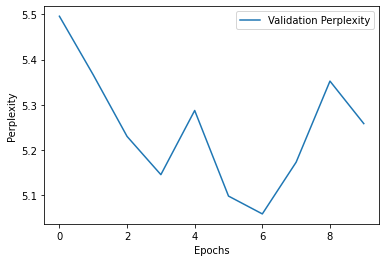

In [2]:
#Plot the change in perplexity during training
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
perplexity = np.exp(val_loss)

epochs_range = range(epochs)

plt.plot(epochs_range, perplexity, label='Validation Perplexity')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.legend()
plt.show()



### Task-2

In [4]:
# Define a function to generate text given a seed sequence
def generate_text(model, seed_sequence, length=100):
    generated_text = seed_sequence
    for i in range(length):
        x_pred = np.zeros((1, seq_length, len(chars)))
        for t, char in enumerate(generated_text):
            x_pred[0, t, char_to_index[char]] = 1

        preds = model.predict(x_pred, verbose=0)[0]
        next_index = np.random.choice(len(chars), p=preds)
        next_char = index_to_char[next_index]

        generated_text += next_char
        generated_text = generated_text[1:]

    return generated_text

# Generate 3 sequences of length 100 by priming with random character sequences of length 5
for i in range(3):
    seed_sequence = ''.join(np.random.choice(chars, size=5))
    generated_sequence = generate_text(model, seed_sequence, length=100)
    print(f"Priming sequence: {seed_sequence}")
    print(f"Generated sequence: {generated_sequence}\n")


Priming sequence: cr!sy
Generated sequence: y;i?;

Priming sequence:  $yww
Generated sequence: .
de.

Priming sequence: '3tq3
Generated sequence: 

:ue



### Task-3

In [19]:
def generate_text(model, seed_sequence, length):
    # Convert the seed sequence to a one-hot encoded input
    x_pred = np.zeros((1, seq_length, len(chars)))
    for t, char in enumerate(seed_sequence):
        x_pred[0, t, char_to_index[char]] = 1

    generated_text = seed_sequence
    for i in range(length):
        preds = model.predict(x_pred, verbose=0)[0]
        
        # Sample the next character index from the predicted probabilities
        def sample(preds, temperature=1.0):
            preds = np.asarray(preds).astype('float64')
            preds = np.log(preds) / temperature
            exp_preds = np.exp(preds)
            preds = exp_preds / np.sum(exp_preds)
            probas = np.random.multinomial(1, preds, 1)
            return np.argmax(probas)
        
        next_index = sample(preds)
        next_char = index_to_char[next_index]

        generated_text += next_char
        generated_text = generated_text[1:]

        # Update the input sequence for the next timestep
        x_pred = np.zeros((1, seq_length, len(chars)))
        for t, char in enumerate(generated_text):
            x_pred[0, t, char_to_index[char]] = 1

    return generated_text


In [23]:
# Define the priming sequences
priming_sequences = ['the', 'wat is', 'shall i give']

# Generate and print the sequences
for seq in priming_sequences:
    generated_sequence = generate_text(model, seq, length=100)
    print(f"Priming sequence: {seq}")
    print(f"Generated sequence: {generated_sequence}\n")


Priming sequence: the
Generated sequence: osl

Priming sequence: wat is
Generated sequence: 
rr,,p

Priming sequence: shall i give
Generated sequence: 
..ssr,ssear

